In [36]:
# Adding packages

using DelimitedFiles
using StatsBase
using Interpolations
using Plots
using LaTeXStrings
using FFTW
using Distributions

In [691]:
# Conversion factor to go from kpc to m
# kpctom = 3.086e19
# kpctocm = 3.086e22


In [4]:
# Reading the model into an array

model_2 = readdlm("second_GC_model.txt", comments=true)
numv = size(model_2)[1]



219074

In [5]:
# Histogramming the distribution

bsize = 0.3
xbins, ybins, zbins = -30:bsize:30, -30:bsize:30, -3:bsize:3
nubins= fit(Histogram, (vec(model_2[:, 24]), vec(model_2[:, 25]), vec(model_2[:, 26])), (xbins, ybins, zbins), closed=:left)

Histogram{Int64, 3, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  -30.0:0.3:30.0
  -30.0:0.3:30.0
  -3.0:0.3:3.0
weights: [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; … ;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
closed: left
isdensity: false

In [6]:
# Interpolating the distribution

binvals = nubins.weights ./ (numv*bsize^3)
xedges = collect(xbins)
yedges = collect(ybins)
zedges = collect(zbins)
pop!(xedges)
pop!(yedges)
pop!(zedges)
pds = interpolate((xedges, yedges, zedges), binvals, Gridded(Linear()))
probdens = extrapolate(pds, fill(0))


200×200×20 extrapolate(interpolate((::Vector{Float64},::Vector{Float64},::Vector{Float64}), ::Array{Float64, 3}, Gridded(Linear())), fill(0)) with element type Any:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  … 

In [7]:
# Downloading and interpolating the effective area data

eff_a = readdlm("EffA_GC_approx.csv", ',')
itp = interpolate((eff_a[:, 1],), eff_a[:, 2], Gridded(Linear())) # in m^2
effarea = extrapolate(itp, fill(0))

31-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), fill(0)) with element type Any:
   0.05232991146814947
   0.09646616199111992
   0.1539926526059492
   0.25482967479793467
   0.3924189758484536
   0.6042963902381329
   0.8976871324473142
   1.2863969449369745
   1.715437896342879
   2.371373705661655
   3.0505278902670256
   3.9241897584845358
   5.0480657166674705
   ⋮
  26.416483203860924
  31.622776601683793
  36.51741272548377
  42.169650342858226
  50.4806571666747
  60.42963902381328
  69.78305848598663
  83.53625469578262
  93.0572040929699
 107.46078283213174
 115.47819846894582
 143.30125702369628

In [8]:
# Core functions defs

function oscprob(et, dm2, leff)

    # Norms for the PMNS matrix squared:
    uₑ = [0.674743, 0.302844, 0.0224125]
    uₘ = [0.0946105, 0.360415, 0.544974]
    uₜ = [0.230646, 0.33674,  0.432613]

    # Conversion factor to go from kpc to 1/eV
    convfactor = 3.086e19 * 5.06773093741 * 1e6

    leff = leff*convfactor

    osc1 = (cos((dm2 * leff)/(4*et*1e12)))^2
    osc2 = (cos((dm2 * leff)/(4*et*1e12)))^2
    osc3 = (cos((dm2 * leff)/(4*et*1e12)))^2

    prob_surv = osc1*(uₑ[1]*uₑ[1]) + osc2*(uₑ[2]*uₑ[2]) + osc3*(uₑ[3]*uₑ[3])
    prob_mue = osc1*(uₑ[1]*uₘ[1]) + osc2*(uₑ[2]*uₘ[2]) + osc3*(uₑ[3]*uₘ[3])
    prob_e = 0.666666*prob_mue + 0.333333*prob_surv 
end

function flux(et, x, y, z)
    ϕ₀ = 10 # TeV^-1 cm^-2 s^-1, completely random, will be able to calculate this directly I think
    e0 = 1 # TeV
    γ = 2.0 # Completely random, not sure how to calculate this exactly
    probdens(x, y, z)[1] * ϕ₀ * (et/e0)^(-γ)
end

function cartesian(r, l, b)
    x = 8 - r*cos(l)*cos(b)
    y = r*sin(l)*cos(b)
    z = r*sin(b)
    return [x, y, z]
end

function cartx(r, l, b)
    x = 8 - r*cos(l)*cos(b)
    return x
end

function carty(r, l, b)
    y = r*sin(l)*cos(b)
    return y
end

function cartz(r, l, b)
    z = r*sin(b)
    return z
end

cartz (generic function with 1 method)

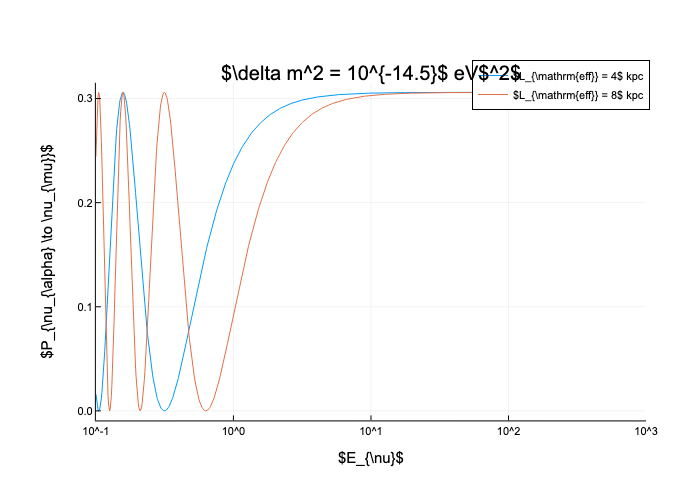

In [9]:
# Plotting osc probs

dm2 = 10^(-14.5)
es = 10 .^ range(-1, 3, length=1000)
y = oscprob.(es, dm2, 4)
z = oscprob.(es, dm2, 8)
plot(es, [y z], title=L"$\delta m^2 = 10^{-14.5}$ eV$^2$", label=[L"$L_{\mathrm{eff}} = 4$ kpc" L"$L_{\mathrm{eff}} = 8$ kpc"], linewidth=1)
plot!(xscale=:log10, minorgrid=true)
xlims!(1e-1, 1e+3)
xlabel!(L"E_{\nu}")
ylabel!(L"P_{\nu_{\alpha} \to \nu_{\mu}}")


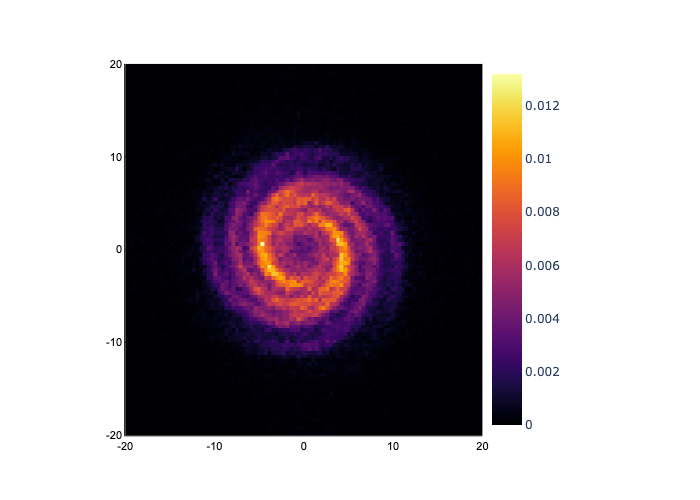

In [10]:
# Plotting neutrino distributions

xs = range(-20, 20, length=100)
ys = range(-20, 20, length=100)

grid = Iterators.product(xs, ys)
zvals = [probdens(x, y, 0) for (x, y) in grid]
zmat = reshape(zvals, length(xs), length(ys))

# z = probdens(xs, ys, 0)
heatmap(xs, ys, zmat, xlims=(-20,20), ylims=(-20,20), aspect_ratio=0.8)

In [11]:
# Perfect event distribution function

function eventdist(et, dm2, l, b)

    r0, rmax = 0, 30
    blength = 0.5
    rbins = range(r0, stop=rmax, step=blength)
    n_bins = trunc(Int, rmax/blength)+1

    flx = flux.(et, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b)) .* blength
    probe = oscprob.(et, dm2, rbins)
    effa = effarea(et)[1]*10000

    sum(.*(flx, probe, effa))
end

eventdist (generic function with 1 method)

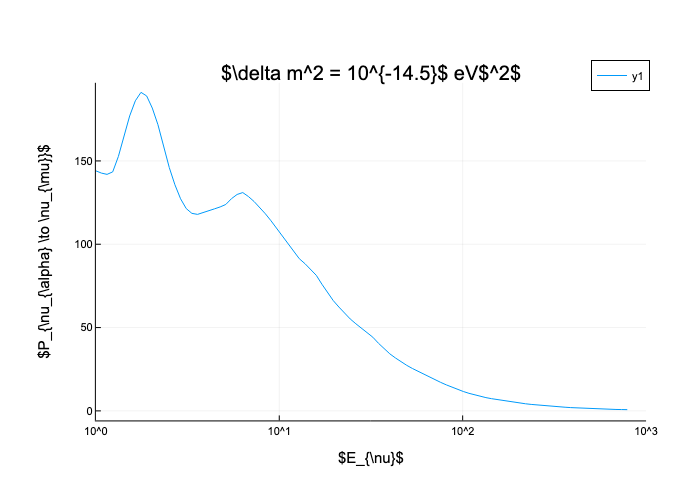

In [12]:
# Plotting perfect event distributions

dm2 = 10^(-14.0)
es = 10 .^ range(log10(0.7), log10(790), length=100)
y = eventdist.(es, dm2, 0, 0)
plot(es, [y], title=L"$\delta m^2 = 10^{-14.5}$ eV$^2$", linewidth=1)
plot!(xscale=:log10, minorgrid=true)
xlims!(1e0, 1e+3)
xlabel!(L"E_{\nu}")
ylabel!(L"P_{\nu_{\alpha} \to \nu_{\mu}}")

In [13]:
# Energy smearing function

function smearedeventdist(logereco, dm2, l, b)

    r0, rmax = 0, 30
    blength = 0.5
    rbins = range(r0, stop=rmax, step=blength)
    nbins = trunc(Int, rmax/blength)
    emin = 0.7916819159263001
    emax = 791.6819159263017
    σ = 0.5

    samples = range(-0.5, log10(emax)+0.5, length=300)
    gauss(u) = pdf(Normal(0, σ), u)
    de = samples[2]-samples[1]

    pdf_func(ur) = log(10) * exp10.(ur .- 0) * pdf(Normal(0, σ), abs(1 - exp10(ur - 0)))
    gsample = pdf_func.(samples)
    g_fft = fft(gsample)

    cartbins = cartesian.(rbins, l, b)

    # u = log e_true, 0.5 translates the Gaussian enough so that the whole thing is in the bounds (for σ = 0.1 at least)

    function convolve(i)

        function f(u)
            etrue = 10^u
            flx = flux(etrue, cartbins[i][1], cartbins[i][2], cartbins[i][3])*blength
            probe = oscprob(etrue, dm2, rbins[i])
            effa = effarea(etrue)[1]*10000
            dist = flx*probe*effa
        end

        fsample = f.(samples)
        f_fft = fft(fsample)
        C = f_fft .* g_fft
        c = real(ifft(C)) .* de
        
        # Translation factor
        # samples1 = samples .+ 0.5
        
        cut = trunc(Int, (0.5)/de)
        c1 = vcat(c[(cut+1):end], zeros(cut))
        
        fg = interpolate((samples,), c1, Gridded(Linear()))
        fg(logereco)
    end

    # events = zeros(nbins)
    # for i in 1:nbins
    #     events[i] = convolve(i, g_fft, samples) * blength
    # end
    events = convolve.(collect(1:nbins)) .* blength
    sum(events)

end


smearedeventdist (generic function with 1 method)

In [14]:

function smearedeventdist2(logereco, dm2, l, b)
    
    function f(ur)
        et = 10^ur
        r0, rmax = 0, 30
        blength = 0.5
        rbins = range(r0, stop=rmax, step=blength)

        flx = flux.(et, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b)) .* blength
        probe = oscprob.(et, dm2, rbins)
        effa = effarea(et)[1]*10000

        sum(.*(flx, probe, effa))
    end

    samples = range(-0.5, log10(emax)+0.5, length=300)
    de = samples[2]-samples[1]

    pdf_func(ur) = log(10) * exp10.(ur .- 0) * pdf(Normal(0, σ), abs(1 - exp10(ur - 0)))
    gsample = pdf_func.(samples)
    g_fft = fft(gsample)

    fsample = f.(samples)
    f_fft = fft(fsample)
    C = f_fft .* g_fft
    c = real(ifft(C)) .* de
    
    # Translation factor
    # samples1 = samples .+ 0.5
    
    cut = trunc(Int, (0.5)/de)
    c1 = vcat(c[(cut+1):end], zeros(cut))
    
    fg = interpolate((samples,), c1, Gridded(Linear()))
    fg(logereco) / 2
end
    
    

smearedeventdist2 (generic function with 1 method)

In [15]:
@time smearedeventdist2(0, 0, 0, 0)

LoadError: UndefVarError: `emax` not defined

In [16]:
# Timing and testing smearing function

@time smearedeventdist(1.4, 10^(-14.3), pi, 0)

  1.974721 seconds (890.72 k allocations: 45.742 MiB, 4.94% gc time, 92.04% compilation time)


2.3649734585295477

In [17]:
#inside function testing

function test(logereco, dm2, l, b)
    
    et = 10^logereco
    r0, rmax = 0, 30
    blength = 0.5
    rbins = range(r0, stop=rmax, step=blength)


    flx = flux.(et, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b)) .* blength
    probe = oscprob.(et, dm2, rbins)
    effa = effarea(et)[1]*10000

    sum(.*(flx, probe, effa))

end


test (generic function with 1 method)

In [18]:
@time test(0, 0, 0, 0)

  0.097182 seconds (18.77 k allocations: 1.215 MiB, 99.77% compilation time)


311.37067478088954

In [19]:
# Plotting unbinned smeared energy dist

loges = range(log10(emin), (log10(emax)+log10(emin)), 100)
es = 10 .^ loges
plot(es, [smearedeventdist2.(loges, 10^(-14.3), pi/8, 0) smearedeventdist2.(loges, 10^(-14.2), pi/8, 0)])
plot!(xscale=:log10, minorgrid=true)

LoadError: UndefVarError: `emin` not defined

In [32]:
# Testing on the inside of the function
emin = 0.7916819159263001
emax = 791.6819159263017
# function convolve(i)

i = 10
r0, rmax = 0, 30
blength = 0.5
rbins = range(r0, stop=rmax, step=blength)

logereco = log10(emax)
σ = 0.5
cartbins = cartesian.(rbins, 0, 0)
samples = range(-0.5, log10(emax)+0.5, length=300)
gauss(u) = pdf(Normal(0, σ), u)

pdf_func(ur) = log(10) * exp10.(ur .- 0) * pdf(Normal(0, σ), abs(1 - exp10(ur - 0)))


function f(u)
    etrue = 10^u
    flx = flux(etrue, cartbins[i][1], cartbins[i][2], cartbins[i][3])*blength
    probe = oscprob(etrue, dm2, rbins[i])
    effa = effarea(etrue)[1]*10000
    dist = flx*probe*effa
end

de = samples[2]-samples[1]
fsample = f.(samples)
gsample = pdf_func.(samples)
f_fft = fft(fsample)
g_fft = fft(gsample)
C = f_fft .* g_fft
c = real(ifft(C)) .* de

# Translation factor
# samples1 = samples .+ 0.5

cut = trunc(Int, (0.5)/de)
c1 = vcat(c[(cut+1):end], zeros(cut))

fg = interpolate((samples,), c1, Gridded(Linear()))
fg(logereco)


0.02015154288979632

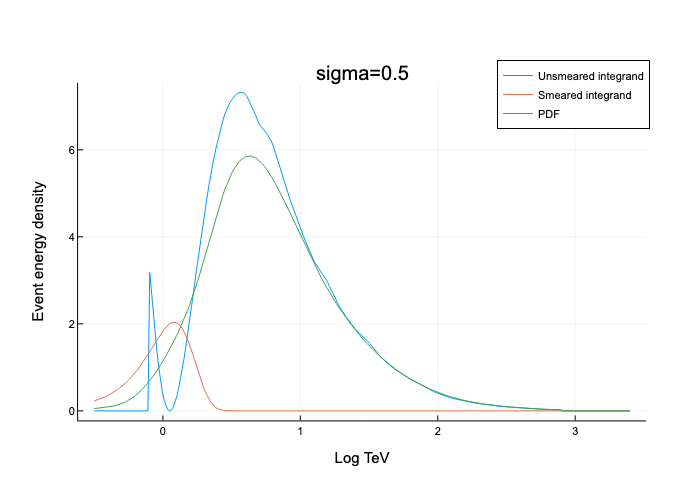

In [37]:
# And plotting
plot(samples, [fsample gsample fg.(samples)], title="sigma=0.5", label=["Unsmeared integrand" "Smeared integrand" "PDF"])
xlabel!("Log TeV")
ylabel!("Event energy density")

In [1223]:
# Binned energy distribution function

function edistbinned(dm2, l, b)
    nbins = 50
    nsteps = 100
    us = range(log10(emin), log10(emax), nsteps)    
    du = us[2] - us[1]
    steps = smearedeventdist2.(us, dm2, l, b) .* du
    matrix = reshape(steps, (2, :))
    sums = sum(matrix, dims=1)
    νbins = vec(sums)
end


edistbinned (generic function with 2 methods)

In [1228]:
@time edistbinned(0, 0, 0)

  2.412553 seconds (22.55 M allocations: 747.860 MiB, 9.28% gc time)


50-element Vector{Float64}:
 4.098745287588266
 5.2266660445253565
 6.377079383903779
 7.388469535894476
 8.10421748348033
 8.463553950308125
 8.535396829038566
 8.437757845783507
 8.239581633944002
 7.961206003451808
 7.609157068923829
 7.192346246584128
 6.724800635343073
 ⋮
 0.198597187912119
 0.16557167762821082
 0.1382149377921294
 0.1153507678690161
 0.09587250324626845
 0.07930697331284636
 0.06518761611196874
 0.053129352772515556
 0.042784625838841836
 0.03385398519002753
 0.02612289182797735
 0.019420130426708787

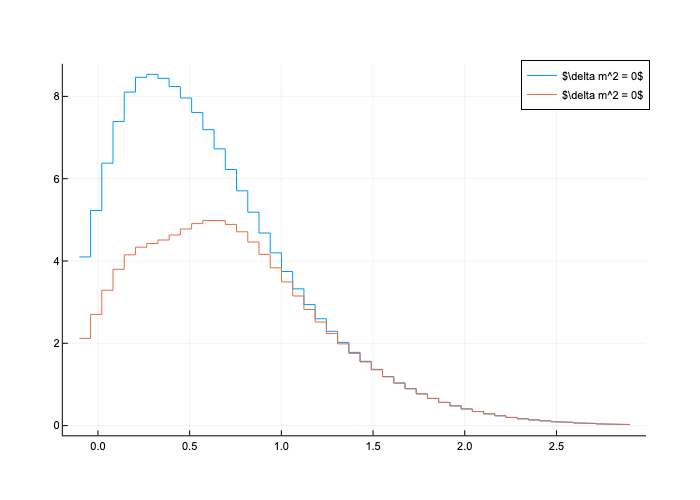

In [1020]:
loges = range(log10(emin), log10(emax), 50)

plot(loges, [edistbinned(0, 0, 0), edistbinned(10^(-14.3), 0, 0)], seriestype=:step, label=L"\delta m^2 = 0")